<table class="tfo-notebook-buttons" align="left">
    <a target="_blank" href="https://colab.research.google.com/github/jaredwinick/what_is_tf_keras/blob/master/What_is_tf_keras_really.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jaredwinick/what_is_tf_keras/blob/master/What_is_tf_keras_really.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


What is `tf.keras` *really*?
============================
This tutorial has been ported to TensorFlow 2.0 by Jared Winick. **All credit for should be given to Jeremy Howard [fast.ai](https://www.fast.ai) and his collaborators Rachel Thomas and Francisco Ingham for the original post ["What is `torch.nn` *really*"](https://pytorch.org/tutorials/beginner/nn_tutorial.html).** Much of the original content has been copied verbatim. I really enjoyed the teaching style of the original and following it while porting to TF 2.0 was very helpful in learning that basics. It should be noted I am no expert in TF so if there are ways to improve the code, please submit a PR! Hopefully this tutorial can be as useful as the original, but for those interested in TensorFlow 2 as opposed to PyTorch.


TensorFlow provides several high-level modules and classes such as [``tf.keras.layers``](https://www.tensorflow.org/api_docs/python/tf/keras/layers),
[``tf.keras.optimizers``](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), and
[``tf.data.Dataset``](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 
to help you create and train neural networks.
In order to fully utilize their power and customize
them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train a basic neural net
on the MNIST data set without using any features from these modules; we will
initially only use the most basic TensorFlow tensor functionality. Then, we will
incrementally add one feature from ``tf.keras.layers``, ``tf.keras.optimizers``, or
``Dataset`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

**This tutorial assumes you already have TensorFlow installed, and are familiar
with the basics of tensor operations.** Using Google Colab is an easy way to start using TensorFlow 2.0 without having to install anything yourself.

MNIST data setup
----------------

We will use the classic [MNIST](http://deeplearning.net/data/mnist/) dataset,
which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use [pathlib](https://docs.python.org/3/library/pathlib.html)
for dealing with paths (part of the Python 3 standard library), and will
download the dataset using
[requests](http://docs.python-requests.org/en/master/). We will only
import modules when we use them, so you can see exactly what's being
used at each point.



In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle,
a python-specific format for serializing data.



In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



In [0]:
%matplotlib inline

(50000, 784)


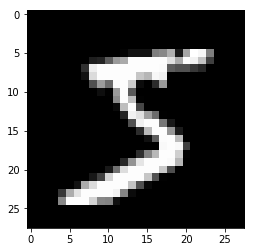

In [50]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

TensorFlow uses ``tf.Tensor``, rather than numpy arrays, so we need to convert out data. We use the function ``tf.constant`` to convert the numpy array into a TensorFlow tensor. See this following for more detail on numpy compatibility https://www.tensorflow.org/tutorials/customization/basics#numpy_compatibility



In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [52]:
import tensorflow as tf

x_train, y_train, x_valid, y_valid = map(
    tf.constant, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train)
print(y_train)
print(f'Min label: {tf.math.reduce_min(y_train).numpy()}')
print(f'Max label: {tf.math.reduce_max(y_train).numpy()}')

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(50000, 784), dtype=float32)
tf.Tensor([5 0 4 ... 8 4 8], shape=(50000,), dtype=int64)
Min label: 0
Max label: 9


Neural net from scratch (no tf.keras)
---------------------------------------------

Let's first create a model using nothing but TensorFlow tensor operations. We're assuming
you're already familiar with the basics of neural networks. (If you're not, you can
learn them at [course.fast.ai](https://course.fast.ai>)).

TensorFlow provides methods to create random or zero-filled tensors, which we will
use to create our weights and bias for a simple linear model. If you are comparing this post with the original using PyTorch, you can see some differences here with respect to how the frameworks are enabling gradients to be calculated. In TensorFlow you don't specify that a tensor requires gradients calculated on the object itself, but by using those tensors in the context of a `tf.GradientTape` as seen in a few paragraphs.

A similar exercise can be see in the TensorFlow documentation [Custom training](https://www.tensorflow.org/tutorials/customization/custom_training)

*Note*: We are initializing the weights here with [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by multiplying with 1/sqrt(n).



In [0]:
import math

weights = tf.Variable(tf.random.normal((784, 10)) / math.sqrt(784))
bias = tf.Variable(tf.zeros(10))

Thanks to TensorFlow's ability to calculate gradients automatically, we can
use any standard Python function (or callable object) as a model! So
let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `log_softmax` and use it. Remember: although TensorFlow
provides lots of pre-written loss functions, activation functions, and
so forth, you can easily write your own using plain python.



In [0]:
def log_softmax(x):
  return x - tf.math.log(tf.math.reduce_sum(tf.math.exp(x), -1, keepdims=True))

def model(xb):
  return log_softmax(xb @ weights + bias)

In the above, the ``@`` stands for the dot product operation. We will call
our function on one batch of data (in this case, 64 images).  This is
one *forward pass*.  Note that our predictions won't be any better than
random at this stage, since we start with random weights.



In [55]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
print(preds[0], preds.shape)

tf.Tensor(
[-2.574955  -2.6288726 -2.3458853 -2.079679  -2.2557921 -2.4567945
 -2.7491755 -2.2003245 -1.7462468 -2.3938751], shape=(10,), dtype=float32) (64, 10)


Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):



In [0]:
def nll(input, target):
    indices = tf.stack([tf.range(input.shape[0], dtype=tf.int64), target], axis=1)
    return tf.math.reduce_mean(-tf.gather_nd(input, indices))

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [57]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tf.Tensor(2.375083, shape=(), dtype=float32)


Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.



In [0]:
def accuracy(out, yb):
    preds = tf.math.argmax(out, axis=1)
    return tf.math.reduce_mean(tf.dtypes.cast(preds == yb, tf.float16))

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



In [59]:
print(accuracy(preds, yb))

tf.Tensor(0.04688, shape=(), dtype=float16)


We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- Under a `tf.GradientTape` context
  - use the model to make predictions
  - calculate the loss
- Compute the gradient of operations recorded in the context of this tape.

We now use these gradients to update the weights and bias. 

Documentation can be seen at 
[``tf.GradientTape``](https://www.tensorflow.org/api_docs/python/tf/GradientTape). 


In [0]:
lr = 0.2  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        with tf.GradientTape() as t:
          pred = model(xb)
          loss = loss_func(pred, yb)

        dW, dB = t.gradient(loss, [weights, bias])
        weights.assign_sub(lr * dW)
        bias.assign_sub(lr * dB)

That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [61]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tf.Tensor(0.24429947, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float16)


Using tf.keras
------------------------------

We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of TensorFlows's ``tf.keras`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible. It does seem like we the ``tf.nn`` module might provide classes that are more directly inline with the original post's use of ``torch.nn`` but I have chosen to jump right to using ``tf.keras`` as it is the recommended higher level API.

The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``tf.keras``.

TensorFlow provides a single function ``tf.keras.losses.SparseCategoricalCrossentropy`` that combines
a softmax activation with a loss function. Note that we use ``from_logit=True`` here because we are not passing in a probability distribution. See https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy



In [0]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def model(xb):
    return xb @ weights + bias

Note that we no longer call ``log_softmax`` in the ``model`` function.



In [63]:
print(loss_func(yb, model(xb)), accuracy(model(xb), yb))

tf.Tensor(0.24429946, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float16)


Refactor using tf.keras.Model
-----------------------------
Next up, we'll use ``tf.keras.Model`` for a clearer and more
concise training loop. We subclass ``tf.keras.Model`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.



In [0]:
class Mnist_Logistic(tf.keras.Model):
    def __init__(self):
      super(Mnist_Logistic, self).__init__()
      self.w = tf.Variable(tf.random.normal((784, 10)) / math.sqrt(784))
      self.b = tf.Variable(tf.zeros(10))

    def call(self, xb):
        return xb @ self.w + self.b

Since we're now using an object instead of just using a function, we
first have to instantiate our model:



In [0]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that
``tf.keras.Model`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes TensorFlow will call our ``call``
method automatically.



In [66]:
print(loss_func(yb, model(xb)))

tf.Tensor(2.5179658, shape=(), dtype=float32)


Previously for our training loop we had to update the values for each parameter
by name, like this:

```
weights.assign_sub(lr * dW)
bias.assign_sub(lr * dB)
```

Now we can take advantage of ``model.trainable_variables`` to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model.

We'll wrap our little training loop in a ``fit`` function so we can run it
again later.



In [0]:
def fit():
  for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      with tf.GradientTape() as t:
        pred = model(xb)
        loss = loss_func(yb, pred)

      gradients = t.gradient(loss, model.trainable_variables)
      for variable, grad in zip(model.trainable_variables, gradients):
        variable.assign_sub(lr * grad)

In [0]:
fit()

Let's double-check that our loss has gone down:



In [69]:
print(loss_func(yb, model(xb)), accuracy(model(xb), yb))

tf.Tensor(0.2520585, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float16)


Refactor using tf.keras.layers.Dense
-------------------------

We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the TensorFlow class
[``tf.keras.layers.Dense``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) for a
linear layer, which does all that for us. TensorFlow has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.



In [0]:
class Mnist_Logistic(tf.keras.Model):
    def __init__(self):
      super(Mnist_Logistic, self).__init__()
      self.linear = tf.keras.layers.Dense(10, input_shape=(None,784))

    def call(self, xb):
        return self.linear(xb)

We instantiate our model and calculate the loss in the same way as before:



In [71]:
model = Mnist_Logistic()
print(loss_func(yb, model(xb)))

tf.Tensor(2.5036383, shape=(), dtype=float32)


We are still able to use our same ``fit`` method as before.



In [72]:
fit()

print(loss_func(yb, model(xb)))

tf.Tensor(0.25161958, shape=(), dtype=float32)


Refactor using tf.keras.optimizers
------------------------------

TensorFlow also has a package with various optimization algorithms, [``tf.keras.optimizers``](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).
We can use the ``apply_gradients`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

```
  for variable, grad in zip(model.trainable_variables, gradients):
    variable.assign_sub(lr * grad)
```

and instead use just:
```
  opt.apply_gradients(zip(gradients, model.trainable_variables))
```



We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [73]:
def get_model():
    model = Mnist_Logistic()
    return model, tf.keras.optimizers.SGD(lr=lr)

model, opt = get_model()
print(loss_func(yb, model(xb)))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        with tf.GradientTape() as t:
          pred = model(xb)
          loss = loss_func(yb, pred)

        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))

print(loss_func(yb, model(xb)))

tf.Tensor(2.5305252, shape=(), dtype=float32)
tf.Tensor(0.2404473, shape=(), dtype=float32)


Refactor using Dataset
------------------------------

TensorFlow provides the [``tf.data.Dataset``](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class as an abstraction over the data needed for machine learning pipelines. A simple way to construct a ``Dataset`` is from existing tensors. The ``Dataset`` can hold the input as well as labels, and also provides an easy way to iterate over batches. For much more info, please see https://www.tensorflow.org/guide/data.


In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

Previously, we had to iterate through minibatches of x and y values separately:
```
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Now, we can do this in a single line:
```
  for xb, yb in train_ds.batch(bs):
```



In [75]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_ds.batch(bs):
        with tf.GradientTape() as t:
          pred = model(xb)
          loss = loss_func(yb, pred)

        gradients = t.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))

print(loss_func(yb, model(xb)))

tf.Tensor(0.24117279, shape=(), dtype=float32)


Thanks to TensorFlows's [``tf.keras.Model``](https://www.tensorflow.org/api_docs/python/tf/keras/Model), [``tf.keras.optimizers``](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), and [``tf.data.Dataset``](https://www.tensorflow.org/api_docs/python/tf/data/Dataset),
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effecive models in practice.

Add validation
-----------------------

In section 1, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a [validation set](https://www.fast.ai/2017/11/13/validation-sets/), in order
to identify if you are overfitting.

Shuffling the training data is
[important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks)
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.



In [0]:
SHUFFLE_BUFFER_SIZE = 100

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(bs)
validation_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(bs * 2)

We will calculate and print the training and validation loss and accuracy at the end of each epoch. To do this we will leverage the [``tf.keras.metrics``](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) module.



In [77]:
model, opt = get_model()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

for epoch in range(epochs):
  for xb, yb in train_ds:
    with tf.GradientTape() as t:
      pred = model(xb)
      loss = loss_func(yb, pred)

      gradients = t.gradient(loss, model.trainable_variables)
      opt.apply_gradients(zip(gradients, model.trainable_variables))

      train_loss(loss)
      train_accuracy(yb, pred)

  for xb, yb in validation_ds:
    pred = model(xb)
    loss = loss_func(yb, pred)

    validation_loss(loss)
    validation_accuracy(yb, pred)  

  # From https://www.tensorflow.org/tutorials/quickstart/advanced
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valiid Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        validation_loss.result(),
                        validation_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  validation_loss.reset_states()
  validation_accuracy.reset_states()

Epoch 1, Loss: 0.4367533028125763, Accuracy: 88.052001953125, Valid Loss: 0.34305909276008606, Valiid Accuracy: 90.1500015258789
Epoch 2, Loss: 0.3235304057598114, Accuracy: 90.90599822998047, Valid Loss: 0.29940706491470337, Valiid Accuracy: 91.6199951171875


Create fit() and get_data()
----------------------------------

We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [0]:
def loss_batch(model, loss_func, xb, yb, metric_loss, metric_accuracy, opt=None):
  with tf.GradientTape() as t:
    pred = model(xb)
    loss = loss_func(yb, pred)

  if opt is not None:
    gradients = t.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

  metric_loss(loss)
  metric_accuracy(yb, pred)
  return loss, len(xb)

``fit`` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.



In [0]:
def fit(epochs, model, loss_func, opt, train_ds, valid_ds):

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  validation_loss = tf.keras.metrics.Mean(name='validation_loss')
  validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

  for epoch in range(epochs):
    for xb, yb in train_ds:
      loss_batch(model, loss_func, xb, yb, train_loss, train_accuracy, opt)

    for xb, yb in valid_ds:
      loss_batch(model, loss_func, xb, yb, validation_loss, validation_accuracy)
       
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Valid Loss: {}, Valiid Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        validation_loss.result(),
                        validation_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()

Now, our whole process of fitting the model can be run in 2 lines of code:



In [80]:
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_ds, validation_ds)

Epoch 1, Loss: 0.4374210238456726, Accuracy: 88.06600189208984, Valid Loss: 0.3246917128562927, Valiid Accuracy: 90.66999816894531
Epoch 2, Loss: 0.32279902696609497, Accuracy: 90.93800354003906, Valid Loss: 0.2960929870605469, Valiid Accuracy: 91.62999725341797


You can use these basic 2 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN
-------------

We are now going to build our neural network with a convolutional layer.
Because none of the functions in the previous section assume anything about
the model form, we'll be able to use them to train a CNN without any modification.

We will use TensorFlow's predefined
[``tf.keras.layers.Conv2D``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) class
as our convolutional layer. We define a CNN with 1 convolutional layers just like the architecture here https://www.tensorflow.org/tutorials/quickstart/advanced

This time when creating the ``SparseCategoricalCrossentropy`` use the default of ``from_logits=False`` because we are doing a softmax in the last layer of the model, so it is already outputing a probability distribution.



In [0]:
class Mnist_CNN(tf.keras.Model):
  def __init__(self):
    super(Mnist_CNN, self).__init__()
    self.reshape1 = tf.keras.layers.Reshape((28,28,1), input_shape=((784,)))
    self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu')
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(128, activation='relu')
    self.d2 = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, xb):
    xb = self.reshape1(xb)
    xb = self.conv1(xb)
    xb = self.flatten(xb)
    xb = self.d1(xb)
    return self.d2(xb)

In [82]:
model = Mnist_CNN()
opt = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

fit(epochs, model, loss_func, opt, train_ds, validation_ds)

Epoch 1, Loss: 0.23629596829414368, Accuracy: 93.24800109863281, Valid Loss: 0.0928812175989151, Valiid Accuracy: 97.50999450683594
Epoch 2, Loss: 0.07652167230844498, Accuracy: 97.6719970703125, Valid Loss: 0.06858094781637192, Valiid Accuracy: 98.02999877929688


tf.keras.Sequential
------------------------

``tf.keras`` has another handy class we can use to simply our code
[``tf.keras.Sequential``](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

The model created with ``Sequential`` is simply:

In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=((784,))),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

opt = tf.keras.optimizers.Adam()

fit(epochs, model, loss_func, opt, train_ds, validation_ds)


Epoch 1, Loss: 0.2498997449874878, Accuracy: 92.91999816894531, Valid Loss: 0.10154058784246445, Valiid Accuracy: 97.1500015258789
Epoch 2, Loss: 0.08210417628288269, Accuracy: 97.53400421142578, Valid Loss: 0.07364194095134735, Valiid Accuracy: 97.79999542236328


Using the built-in ``fit``
--------------------------
``tf.keras.Model`` has built-in functions for training and evaluating models so that we don't have to write our own like we did above. The documention at https://www.tensorflow.org/api_docs/python/tf/keras/Model provides detail on the ``compile``, ``fit``, and ``evaluate`` functions used below.


In [84]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=((784,))),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, epochs=2)
model.evaluate(validation_ds)

Epoch 1/2
782/782 [==============================] - 6s 8ms/step - loss: 0.2514 - accuracy: 0.9269
Epoch 2/2
79/79 [==============================] - 0s 5ms/step - loss: 0.0703 - accuracy: 0.9779


[0.07032434737510225, 0.9779]

Using your GPU
---------------

If you're lucky enough to have access to a CUDA-capable GPU (as you would if you are running this in Google Colab) you can
use it to speed up your code. First check that your GPU is working in
TensorFlow:



In [85]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Luckily TensorFlow will automatically use a GPU if one is present. If you would like to have fine-grained control of how your operations are run on CPU and GPU devices, see https://www.tensorflow.org/guide/gpu


Closing thoughts
-----------------

Again, all credit for this tutorial should really go to the originial authors of ["What is ``torch.nn`` *really*?"](https://pytorch.org/tutorials/beginner/nn_tutorial.html) Jeremy Howard of [fast.ai](https://fast.ai) with Rachel Thomas and Francisco Ingham. I have really enjoyed the teaching style that Jeremy and Rachel use in their fast.ai courses, and the original tutorial felt very similar to fast.ai material. If you like that teaching style as well, I would highly recommend walking through with the original in PyTorch, or this version with TensorFlow, to get a better feel for what is going on inside these frameworks.

From my personal perspective as an engineer, the high-level APIs available in TensorFlow (or PyTorch) are making it easier and easier to apply deep learning. It is an exciting time to see so much progress in lowering the barrier to entry and improving the tools engineers/scientists/researchers have to solve problems.